In [1]:
backtest_frame_path = 'E:\\backtest-frame'
data_path = "E:\\base_data"
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['font.size'] = '20' # 设置字体大小 = '16' # 设置字体大小
sns.set()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import sys 
sys.path.append(backtest_frame_path)


from datetime import datetime
from tqdm import tqdm
from multiprocessing import Pool,cpu_count



In [2]:

from Data import Data
from TimingFactor import TimingFactor
from BackTest import BackTest
from TDayProcessor import TDayProcessor
from TushareDownloader import TushareDownloader
from utils import *


%load_ext autoreload
%autoreload 2


date_col = 'TradingDay'
secu_col = 'SecuCode'
key_col = [date_col,secu_col]

In [3]:
DB = Data(data_path,update=False)

In [4]:
df = TushareDownloader.pro.moneyflow(trade_date='20190315')

In [6]:
DB.moneyflow_df

,SecuCode,TradingDay,buy_sm_vol,buy_sm_amount,sell_sm_vol,sell_sm_amount,buy_md_vol,buy_md_amount,sell_md_vol,sell_md_amount,buy_lg_vol,buy_lg_amount,sell_lg_vol,sell_lg_amount,buy_elg_vol,buy_elg_amount,sell_elg_vol,sell_elg_amount,net_mf_vol,net_mf_amount
562,000001,2015-01-05,437408,69802.50,446317,71297.53,842852,134542.82,841904,134452.01,880731,140501.41,849612,135592.18,699446,111691.52,722603,115196.53,83968,13784.39
1945,000002,2015-01-05,886336,131456.05,889748,132066.70,1602194,237498.22,1551139,229998.26,1696346,251000.65,1635364,242093.57,2375960,350115.45,2484585,365911.85,209604,32490.99
247,000004,2015-01-05,11530,1794.87,10651,1662.48,13406,2088.61,12478,1944.26,3159,491.16,4966,767.91,0,0.00,0,0.00,-4239,-657.06
771,000006,2015-01-05,259197,18619.92,250237,17978.12,361131,25953.65,336194,24151.85,323838,23278.88,320682,23046.56,134469,9681.16,171521,12357.09,-72330,-5173.63
1082,000007,2015-01-05,9647,1399.12,9759,1418.33,12056,1749.93,10920,1585.11,6654,965.67,7737,1119.80,58,8.53,0,0.00,-2069,-297.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,688798,2023-08-07,10374,7562.11,9781,7125.73,4886,3555.60,4746,3457.89,898,653.78,1793,1305.25,161,117.38,0,0.00,2446,1792.18
3146,688799,2023-08-07,3578,1492.38,4772,1991.51,4130,1722.83,3577,1491.47,2294,956.48,1655,689.27,1,0.56,0,0.00,-2677,-1114.06
1483,688800,2023-08-07,3683,1824.50,4449,2204.24,3370,1668.49,2633,1302.30,1480,732.00,1452,718.45,0,0.00,0,0.00,-259,-126.26
3438,688819,2023-08-07,7620,2822.60,7297,2704.02,2892,1071.70,2902,1074.82,510,189.69,824,305.14,0,0.00,0,0.00,-1014,-373.33


In [21]:
DB._update_daily()

<function Data.Data._update_daily(self, file_name: str, down_load_function)>

# 一、动量类因子

## 1.1 长端动量因子

In [92]:
df = DB.daily_df.copy()
df['Amplitude'] = (df['high'] - df['low']) / df['low']
df.merge(DB.)


In [5]:
# def _calc_mom(df):
    
#     factor = df[df['Amplitude'] <= df['Amplitude'].median()]['raw_close_close'].sum()
#     idx = df.index.values[-1]
    
#     return (idx, factor)


# pool = Pool(12)
# rst_iter = pool.imap(_calc_mom, list(df.groupby('SecuCode').rolling(20)))
# rst_list = list(tqdm(rst_iter,total = len(df)))

# pool.close()
# pool.join()

In [93]:
rst = dict()
for _df in tqdm(df.groupby('SecuCode').rolling(160), total=len(df)):
    if _df.shape[0]  < 120:
        continue
    rst[_df.index.values[-1]] = _df[_df['Amplitude'] <= _df['Amplitude'].median()]['raw_close_close'].sum()
    
factor_col = 'mom_longEndMom_160D'
factor_se = pd.Series(rst).rename(factor_col)
df[factor_col] = factor_se
factor_df = df[['TradingDay','SecuCode','mom_longEndMom_160D']]

  0%|          | 119/7571653 [00:01<29:31:56, 71.22it/s]


KeyError: 'raw_close_close'

In [ ]:
# factor_df = pd.('../factors/mom_longEndMom_160D.csv',index_col = 0)
# factor_df['SecuCode'] = factor_df['SecuCode'].astype(str).str.pad(6,side='left',fillchar='0')
# factor_df['TradingDay'] = factor_df['TradingDay'].astype('datetime64[ns]')
# factor_df.head(3)
# factor_df = pd.read_pickle('../factors/mom_longEndMom_160D.pkl')
factor_df.to_pickle('../factors/mom_longEndMom_160D.pkl')

1. Factor Histogram


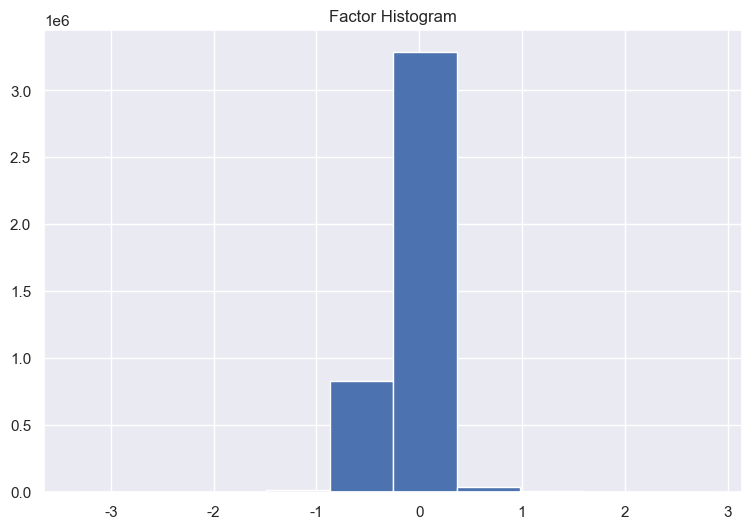

2. Quantile ts plot


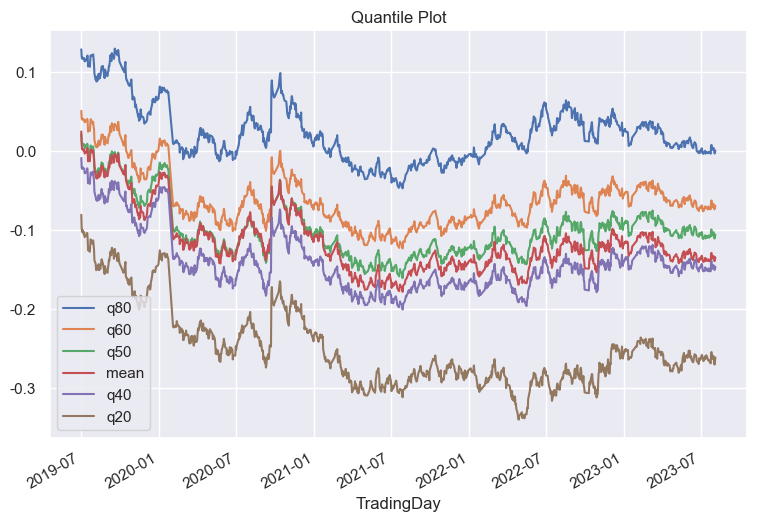

3. Factor Autocorrelation


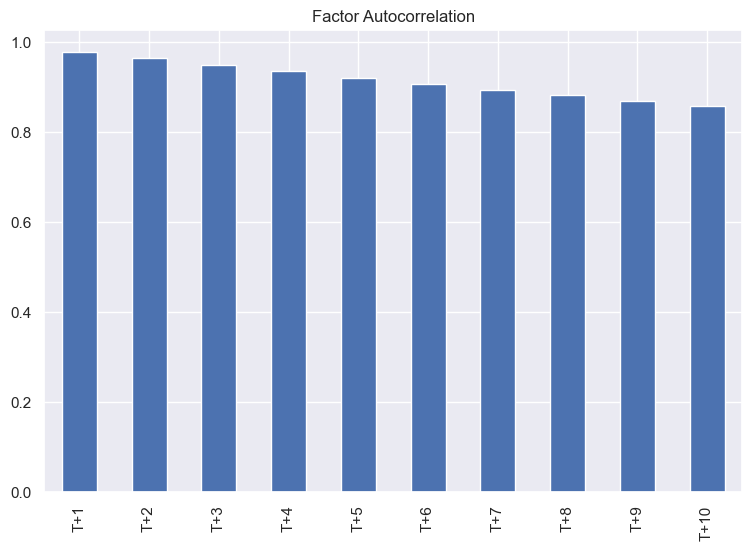

4. Factor Correlation


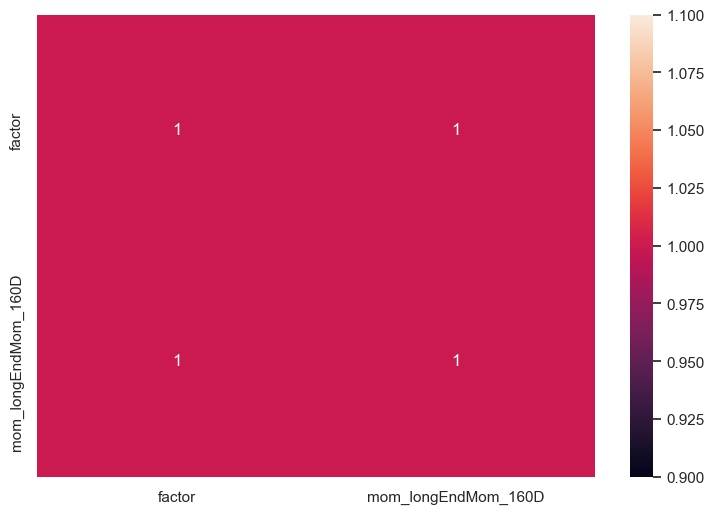

,IC(%),t-value,IC+(%),IC-(%),RankIC(%),ICIR,Winning Rate(%),IC_Min(%),IC_Max(%)
total,2.654724,11.582197,0.674025,2.019455,4.569999,0.406669,67.269076,-20.189551,23.253659
2019,2.168871,6.779895,0.393783,1.770960,4.369509,0.690502,77.600000,-10.732046,8.335633
2020,2.278751,4.916127,0.466617,1.810930,3.423504,0.403592,63.786008,-11.701136,22.946811
2021,2.659721,5.788182,0.826219,1.826029,4.456619,0.451438,69.958848,-20.189551,15.709759
2022,2.549697,5.234343,0.723024,1.801716,4.657385,0.309400,63.223140,-19.001099,23.253659
2023,3.887562,5.843585,0.823779,3.061607,6.738276,0.505076,66.433566,-18.142589,22.263337


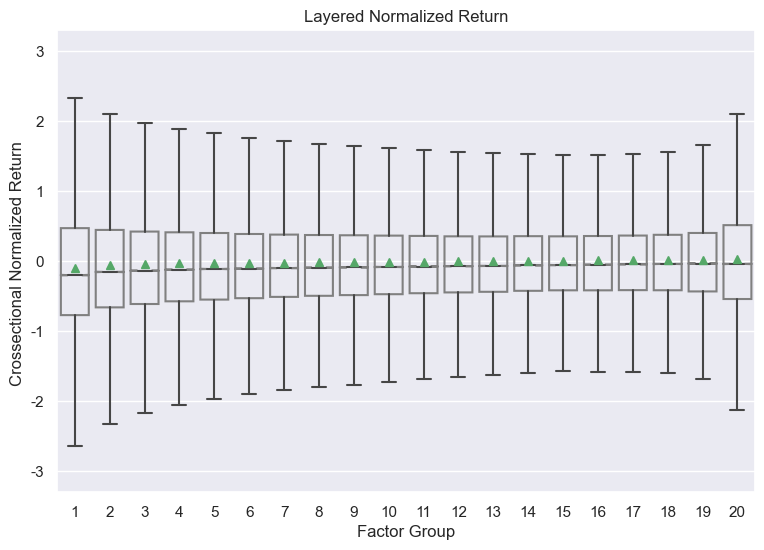

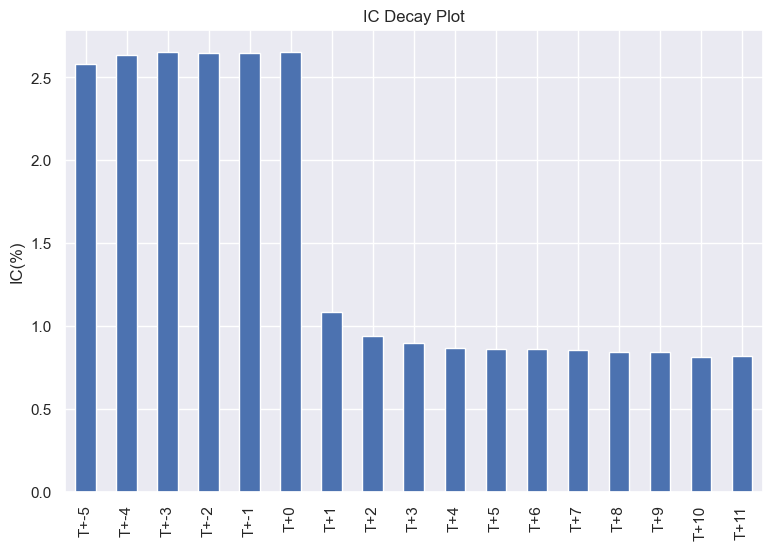

KeyError: 'return'

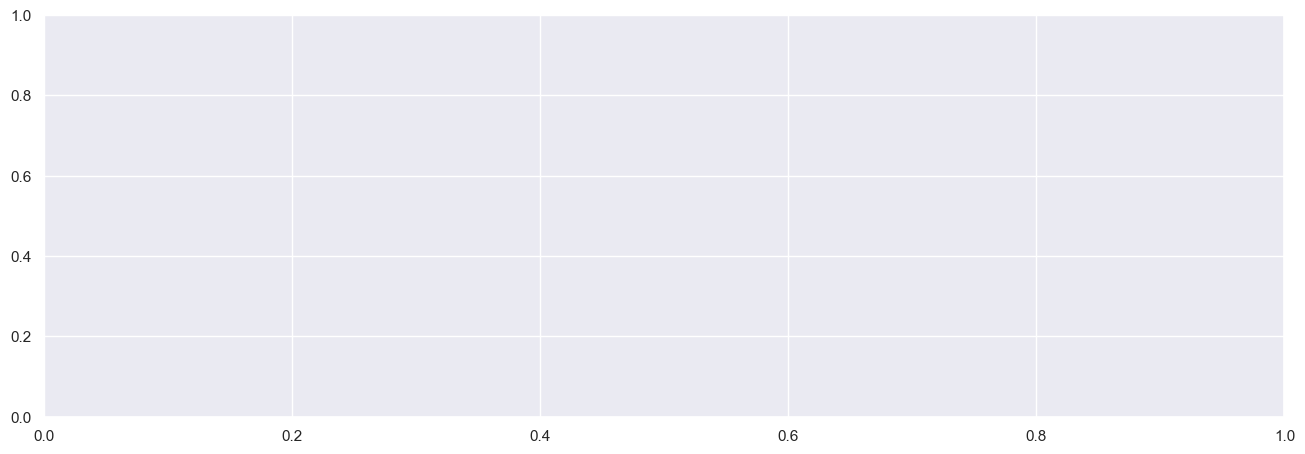

In [ ]:
BT = BackTest(factor_df)
BT.wrapped_analysis(DB.ret_df)

# 测试

In [54]:

from TushareDownloader import TushareDownloader

In [ ]:
TushareDownloader.download_index_all('20190101','20190601','399300.SZ')

('20190901', '20191002')